In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_digits

# Generative Model - Using Kernel Density Estimation

**What** is a density estimator?

A density estimator is an algorithm that takes a __D__-dimensional dataset and produces an estimate of the __D__-dimensional probability distribution which that data is drawn from
 - $P(X_1, . . .X_n)$

The probability density function of a continuous random variable, is a function whose value at any given sample in the sample space can be interpreted as providing a relative likelihood that the value of the random variable would equal that sample. Thus, we can use the pdf to calculate the probability a given data point lies within an interval. 

**Why** use KDE?

Problem with using histogram as density estimator is that the choice of bin size and locations can lead to incaccurate estimations

KDE Hyperparameters:
 - Bandwidth = It is the knob that controls the bias–variance trade-off in the estimate of density:
    - Too narrow a bandwidth leads to a high-variance estimate (i.e., over-fitting), where the presence or absence of a single point makes a large difference. 
    - Too wide a bandwidth leads to a high-bias estimate (i.e., under-fitting) where the structure in the data is washed out by the wide kernel.

**Goal**:
 - Create a generative classifier using Bayes theorem: $P(Y = y | X)$ $\propto$ $P(X | Y)*P(Y)$

Problems:
 - KDE is known to be very computationally expensive

In [4]:
cover = pd.read_csv('/Users/gabestechschulte/Downloads/covertype.csv')
cover.drop('Unnamed: 0', axis=1, inplace=True)
#cover.head()

fish = pd.read_csv('/Users/gabestechschulte/Downloads/Fish.csv')
fish.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [19]:
X_cover = np.array(cover.iloc[:, 0:2])
y_cover = np.array(cover.iloc[:, -1])

X_cover.shape, y_cover.shape

((581012, 2), (581012,))

In [5]:
le = LabelEncoder()
fish.Species = le.fit_transform(fish.Species)

In [40]:
X, y = fish[['Weight', 'Length1', 'Length2', 'Length3', 'Height', 'Width']].values, fish['Species']
X.shape, y.shape

((159, 6), (159,))

In [4]:
#X = np.array(cover.iloc[0:1000, 0:2])
#y = np.array(cover.iloc[0:1000, -1])

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### 1d Feature Example

<AxesSubplot:ylabel='Density'>

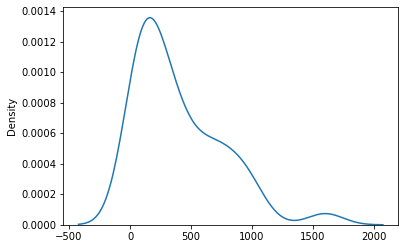

In [12]:
sns.kdeplot(X_train[:, 0])

In [41]:
bandwidths = 10 ** np.linspace(0.0, 1.2, 100)
grid = GridSearchCV(KernelDensity(kernel = 'gaussian'),
                   {'bandwidth': bandwidths})

grid.fit(X[:, 0].reshape(-1, 1))
#grid.best_params_['bandwidth']

GridSearchCV(estimator=KernelDensity(),
             param_grid={'bandwidth': array([ 1.        ,  1.02830326,  1.05740759,  1.08733567,  1.11811082,
        1.149757  ,  1.18229887,  1.21576178,  1.2501718 ,  1.28555573,
        1.32194115,  1.35935639,  1.39783061,  1.43739377,  1.4780767 ,
        1.51991108,  1.56292952,  1.60716552,  1.65265354,  1.69942902,
        1.7475284 ,  1.79698915,  1.8478498 ,  1.90014997,  1.9539304 ,
        2.009233  ,  2.06610084,...
        6.13590727,  6.30957344,  6.48815493,  6.67179086,  6.86062429,
        7.05480231,  7.25447621,  7.45980152,  7.67093822,  7.88805077,
        8.11130831,  8.34088477,  8.57695899,  8.81971488,  9.06934155,
        9.32603347,  9.58999061,  9.86141859, 10.14052888, 10.42753889,
       10.72267222, 11.02615879, 11.33823501, 11.65914401, 11.98913578,
       12.32846739, 12.6774032 , 13.03621502, 13.40518239, 13.78459273,
       14.17474163, 14.57593301, 14.98847941, 15.41270223, 15.84893192])})

In [42]:
kde = KernelDensity(bandwidth = grid.best_params_['bandwidth'],
                    kernel='gaussian').fit(X_train[:, 0].reshape(-1, 1))
logprobs = kde.score_samples(X_train[:, 0].reshape(-1, 1))
probs = np.exp(logprobs)
len(probs), probs.max()

111

## Generative Model

$P(Y = y | X)$ $\propto$ $P(X | Y)*P(Y)$

In [42]:
class KDEClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
    
    def fit(self, X, y):
        
        # Unique classes in the training data
        self.classes_ = np.sort(np.unique(y))
        
        # Identify observations in training set for unique classes - 5 classes means 5 training sets
        # This is used in the next steps for the likelihood function
        training_sets = [X[y == yi] for yi in self.classes_]
        
        # Fit a KDE for each unique class observation in training sets: P(X | Y) aka likelihood function
        # When "Y = y", how does the distribution of "X" change?
        self.models_ = [KernelDensity(bandwidth = self.bandwidth,
                                     kernel = self.kernel).fit(Xi)
                       for Xi in training_sets]
        
        # Prior belief based on the number of samples: P(Y) aka prior
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                          for Xi in training_sets]
        # Probs density of observing the class
        #print(np.exp(self.logpriors_))
        
        return self
    
    def predict_probability(self, X):
        
        # Score samples returns the log of the probability density function (pdf)
        # For each model, return the score on the feature vector in a transposed array
        logprobs = np.array([model.score_samples(X)
                            for model in self.models_]).T
        
        # Exponentiate since it was returned in log form
        results = np.exp(logprobs + self.logpriors_)
        
        return results / results.sum(1, keepdims = True)
    
    def predict(self, X):
        
        # Return the class that has the highest probability given the observed feature(s)
        # Posterior = P(Y | X)
        return self.classes_[np.argmax(self.predict_probability(X), 1)]

### Under the Hood

In [26]:
classes = np.sort(np.unique(y))
training_sets = [X[y == yi] for yi in classes]
models = [KernelDensity(bandwidth = 1, kernel = 'gaussian').fit(Xi) for Xi in training_sets]
logpriors = [np.log(Xi.shape[0] / X.shape[0]) for Xi in training_sets]
logprobs = np.array([model.score_samples(X) for model in models]).T
results = np.exp(logprobs + logpriors)

$P(X | Y = y)$

When $Y = y$, how does the distribution of $X$ change? 
 - Therefore, we are looking at the change in the features distribution conditioning on the class 

In [25]:
len(training_sets) ## 7 unique values, so 7 training sets 

7

In [27]:
models ## 3 training sets, so 3 models

[KernelDensity(bandwidth=1),
 KernelDensity(bandwidth=1),
 KernelDensity(bandwidth=1),
 KernelDensity(bandwidth=1),
 KernelDensity(bandwidth=1),
 KernelDensity(bandwidth=1),
 KernelDensity(bandwidth=1)]

$P(Y)$ = Prior belief about our unique classes 

In [29]:
sum(np.exp(logpriors)) ## probability of observing each respective class given the inputed training sets

1.0

In [35]:
np.exp(logprobs).shape ## log of the probability density function for features using the 7 training sets

(159, 7)

In [31]:
classes[np.argmax(results / results.sum(1, keepdims=True))]

0

In [43]:
bandwidths = 10 ** np.linspace(0, 2, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths})
grid.fit(X_train, y_train)

/Users/gabestechschulte/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/gabestechschulte/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
/Users/gabestechschulte/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
/Users/gabestechschulte/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
/Users/gabestechschulte/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
/Users/gabestechschulte/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
/Users/g

GridSearchCV(estimator=KDEClassifier(),
             param_grid={'bandwidth': array([  1.        ,   1.04761575,   1.09749877,   1.149757  ,
         1.20450354,   1.26185688,   1.32194115,   1.38488637,
         1.45082878,   1.51991108,   1.59228279,   1.66810054,
         1.7475284 ,   1.83073828,   1.91791026,   2.009233  ,
         2.10490414,   2.20513074,   2.3101297 ,   2.42012826,
         2.53536449,   2.65608778,   2.7825594 ,   2.91505306,
         3.05385551,   3.19926714,   3.3516026...
        23.64489413,  24.77076356,  25.95024211,  27.18588243,
        28.48035868,  29.8364724 ,  31.2571585 ,  32.74549163,
        34.30469286,  35.93813664,  37.64935807,  39.44206059,
        41.320124  ,  43.28761281,  45.34878508,  47.50810162,
        49.77023564,  52.14008288,  54.62277218,  57.22367659,
        59.94842503,  62.80291442,  65.79332247,  68.92612104,
        72.20809018,  75.64633276,  79.24828984,  83.02175681,
        86.97490026,  91.11627561,  95.45484567, 100.

In [44]:
print(grid.best_params_)
print(grid.best_score_)

{'bandwidth': 12.328467394420665}
0.5142292490118577
